# Problem Description

The railway industry faces various challenges related to maintenance, safety, and operational efficiency. Traditional maintenance practices often rely on fixed schedules or reactive approaches, which can lead to unexpected breakdowns, service disruptions, and high maintenance costs. Moreover, the lack of real-time insights into the health of railway infrastructure and rolling stock makes it difficult to plan maintenance effectively.

To address these issues, the "Predictive Railway Maintenance" project aims to develop an advanced predictive maintenance system. This system will utilize data analytics, machine learning, and IoT technologies to predict potential failures and maintenance needs in railway assets. By predicting maintenance requirements in advance, the project aims to optimize maintenance schedules, reduce unplanned downtime, and ultimately minimize maintenance costs.

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.linear_model import Lasso,Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
#to display all the graph in the workbook 
sns.set_style("whitegrid",{'grid.linestyle': '--'})
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # For regression tasks
from sklearn.ensemble import RandomForestClassifier  # For classification tasks
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score  # For evaluation

# Loading The Dataset

In [2]:
df=pd.read_csv("Maintenance_History.csv" ,  encoding = "ISO-8859-1")

In [3]:
# Getting feel of the data
df.head()

,Component ID,Component Type,Component Age,Component Specifications,Maintenance Activity,Maintenance Duration,Temperature,Vibration,Pressure,Voltage,Failure Causes,Humidity,Failure History,Maintenance Cost,Rainfall,Mean Time to Repair
0,C001,Cooling Fan,10,1500 RPM,"['p3', 'p2', 'c2']",4,25.3,0.1,1017,24,Mechanical Faults,66,"['F1', 'F4']",6983,0.8,9
1,C002,Coupling Rod,10,Carbon Steel,['c2'],1,35.8,0.4,1012,24,Corrosion,59,"['F1', 'F2', 'F3']",6111,0.1,8
2,C003,Brake Pad,6,NaN,"['p2', 'c2']",1,29.9,0.1,1014,24,Corrosion,66,"['F1', 'F2', 'F3']",7568,0.6,10
3,C004,Switch,7,Toggle,"['p1', 'c1']",6,31.0,0.1,1013,24,Corrosion,63,"['F1', 'F2', 'F3', 'F4']",8633,0.3,7
4,C005,Capacitor,6,1000 µF,['p3'],4,36.5,0.5,1013,24,Overloading,62,['F1'],10578,0.5,7


In [4]:
# Data shape
df.shape


(1100, 16)

In [5]:
# data dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Component ID              1100 non-null   object 
 1   Component Type            1100 non-null   object 
 2   Component Age             1100 non-null   int64  
 3   Component Specifications  952 non-null    object 
 4   Maintenance Activity      1100 non-null   object 
 5   Maintenance Duration      1100 non-null   int64  
 6   Temperature               1100 non-null   float64
 7   Vibration                 1100 non-null   float64
 8   Pressure                  1100 non-null   int64  
 9   Voltage                   1100 non-null   int64  
 10  Failure Causes            1100 non-null   object 
 11  Humidity                  1100 non-null   int64  
 12  Failure History           1100 non-null   object 
 13  Maintenance Cost          1100 non-null   int64  
 14  Rainfall

In [6]:
# Statistical info 
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Component ID,1100,1100,C001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Component Type,1100,51,Brake Pad,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Component Age,1100.0,NaN,NaN,NaN,5.472727,2.865213,1.0,3.0,5.0,8.0,10.0
Component Specifications,952,105,48 V,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maintenance Activity,1100,151,['c2'],66,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maintenance Duration,1100.0,NaN,NaN,NaN,4.52,2.29264,1.0,3.0,5.0,7.0,8.0
Temperature,1100.0,NaN,NaN,NaN,31.623091,4.739735,23.4,27.6,31.6,35.7,39.8
Vibration,1100.0,NaN,NaN,NaN,0.301273,0.143269,0.1,0.2,0.3,0.4,0.5
Pressure,1100.0,NaN,NaN,NaN,1015.02,3.194849,1010.0,1012.0,1015.0,1018.0,1020.0
Voltage,1100.0,NaN,NaN,NaN,24.0,0.0,24.0,24.0,24.0,24.0,24.0


In [7]:
# Checking null values of data 
df.isna().sum()

Component ID                  0
Component Type                0
Component Age                 0
Component Specifications    148
Maintenance Activity          0
Maintenance Duration          0
Temperature                   0
Vibration                     0
Pressure                      0
Voltage                       0
Failure Causes                0
Humidity                      0
Failure History               0
Maintenance Cost              0
Rainfall                      0
Mean Time to Repair           0
dtype: int64

In [8]:
#drop the rows with null values 
df.dropna(inplace=True)
df.shape

(952, 16)

In [9]:
# Checking duplicate
df.duplicated().sum()

0

By observing the dataset, it feels like the voltage column has the same values for every row

In [10]:
#checking for unique values
unique_values = df['Voltage'].nunique()

if unique_values == 1:
    print("All values in the column are the same.")
else:
    print("Values in the column are not all the same.")


All values in the column are the same.


we can see that the voltage column has the same values for every row and component ID does not provide any significant information, so we drop these columns 

In [11]:
df.drop(columns=['Component ID','Voltage'],inplace=True)

# Exploratory data analysis

The given categorical feature  'Component Specifications' seems to contain a mix of different component specifications, and each entry includes various parameters like RPM, cooling capacity, voltage, material, etc. To extract more meaningful information from this feature, we can perform feature engineering by splitting the given information into separate columns for each parameter.

In [12]:
#Spilitting Component Specifications into new columns 

# Checking unique values in the 'Component Specifications' column
print(df['Component Specifications'].unique())

# Step 1: Extracting numeric specifications and creating a new column "Numerical Specifications"
def extract_numerical_specs(spec):
    try:
        return float(re.findall(r'\d+\.*\d*', spec)[0])
    except IndexError:
        return np.nan

df['Numerical Specifications'] = df['Component Specifications'].apply(extract_numerical_specs)
df['Numerical Specifications'] = df['Numerical Specifications'].astype(float)

# Step 2: Creating a new column "Non-Numerical Specifications" for non-numeric specifications
def extract_non_numerical_specs(spec):
    try:
        return spec if not re.findall(r'\d+\.*\d*', spec) else np.nan
    except IndexError:
        return spec

df['Non-Numerical Specifications'] = df['Component Specifications'].apply(extract_non_numerical_specs)

# Step 3: Drop the original "Component Specifications" column 
df.drop(columns=['Component Specifications'], inplace=True)
df.shape

['1500 RPM' 'Carbon Steel' 'Toggle' '1000 µF' '1000 KVA' '50 ohms'
 'Cooling capacity 5000 BTU' 'Pressure' 'Electromagnetic'
 'Cooling capacity 6000 BTU' 'Porcelain' '80 mm diameter'
 'Stainless Steel' 'Copper' '200 V' 'Solenoid Valve' '120 db' '10 kW'
 'Electrical' 'Iron' 'Automatic' '20 kW' 'Polystyrene' ' Steel' 'Silver'
 '30 kW' '300 tons' 'Disc Brakes' '500 RPM' '120 mm diameter' 'Sterlant'
 'LED 6000 luminious flux' '25.4 mm' 'Steel' '10000 µF'
 'Cooling capacity 10000 BTU' '100 mm' 'Thermal' 'Alloy Steel' '100 A'
 '200 tons' 'Magnetic' '110 V' '100 V AC' 'Lubricated Bearings' '48 V'
 '50 mm' '220 V' '400 KVA' 'Pressure Valve' '24 V' '500 tons' '30.2 mm'
 '2000 l' 'Ball Bearings' '1000 l/m' '0.5 m' 'Composite' 'Standard Gauge'
 'Carbon' 'Aluminium' 'Manual' 'Hydraulic Brakes' '500 V' '200 KVA'
 'LED 5000 luminious flux' '3000 KVA' '150 mm' '1000 RPM' 'IP63' 'Silicon'
 '20 mm' '1500 l' '1.5m' 'Broad Gauge' 'Narrow Gauge' '10 ohms' '500 l'
 'Air Filter' 'Diesel Engine' '1000 l' 'Vi

(952, 15)

For extracting more information from the features it is good to divide dataset into Categorical and Numerical features

In [13]:
# Divide Data in categorical and numerical features
numeric_features= df.select_dtypes(exclude='object')
categorical_features=df.select_dtypes(include='object')

In [14]:
numeric_features.head()

,Component Age,Maintenance Duration,Temperature,Vibration,Pressure,Humidity,Maintenance Cost,Rainfall,Mean Time to Repair,Numerical Specifications
0,10,4,25.3,0.1,1017,66,6983,0.8,9,1500.0
1,10,1,35.8,0.4,1012,59,6111,0.1,8,NaN
3,7,6,31.0,0.1,1013,63,8633,0.3,7,NaN
4,6,4,36.5,0.5,1013,62,10578,0.5,7,1000.0
5,8,6,27.0,0.5,1015,66,11888,0.3,2,1000.0


In [15]:
categorical_features.head()

,Component Type,Maintenance Activity,Failure Causes,Failure History,Non-Numerical Specifications
0,Cooling Fan,"['p3', 'p2', 'c2']",Mechanical Faults,"['F1', 'F4']",NaN
1,Coupling Rod,['c2'],Corrosion,"['F1', 'F2', 'F3']",Carbon Steel
3,Switch,"['p1', 'c1']",Corrosion,"['F1', 'F2', 'F3', 'F4']",Toggle
4,Capacitor,['p3'],Overloading,['F1'],NaN
5,Transformer,"['p3', 'c3']",Overloading,"['F1', 'F3']",NaN


In [16]:
# checking categorical column value count
for i in categorical_features.columns:
    print("\n ")
    print('column name  : ', i)
    print(df[i].value_counts())


 
column name  :  Component Type
Relay              30
Chain              28
Brakes             27
Transformer        25
Air Compressor     25
Coupling Rod       25
Signaling          24
Pantograph         24
Bogie              24
Coupler            23
Lighting           23
Doors              23
Engine             22
Axle               22
Controller         22
Bearings           22
Cooling Fan        22
Track              21
Horn               21
Capacitor          21
Shaft              21
Inverter           20
Alternator         20
Insulator          20
Roller             20
Cylinder           20
Resistor           20
Seal               20
Circuit Breaker    19
Heat Exchanger     19
Gear               19
Gasket             19
Valve              19
Belt               18
Charger            16
Motor              16
Brake Pad          15
Wheels             15
Converter          14
Fuse               14
Sensors            14
Wheelset           14
Panel              13
Filter             1

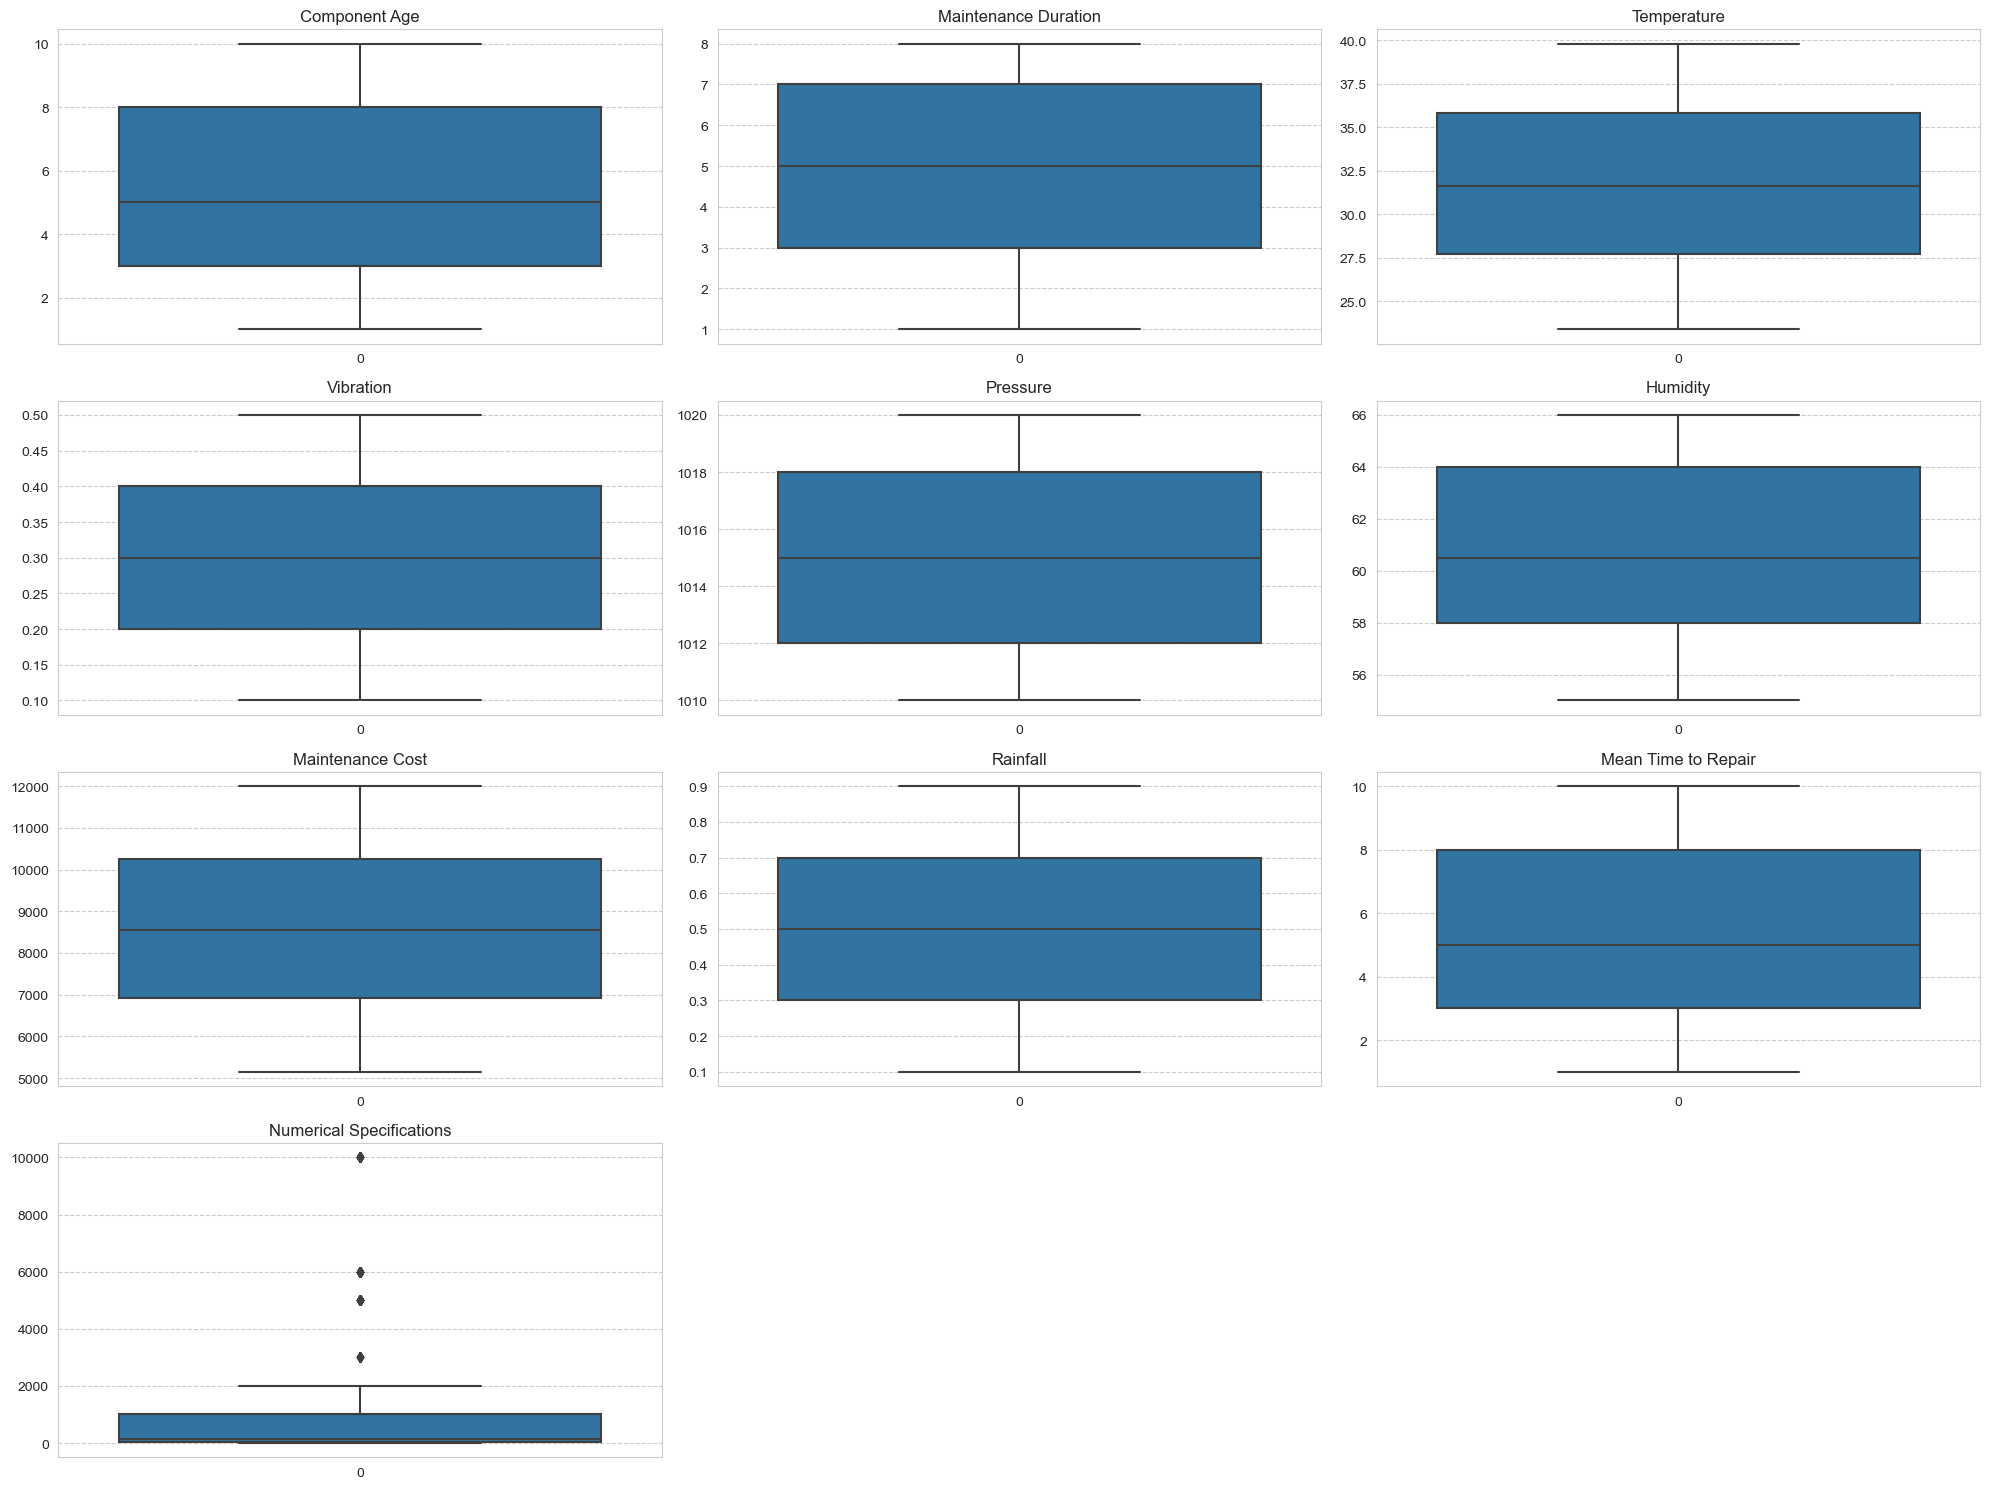

In [17]:
# checking Outliers with seaborn boxplot
plt.figure(figsize=(20, 15))

n = 1
for i in numeric_features.columns:
    plt.subplot(4, 3, n)
    n = n + 1
    sns.boxplot(df[i])
    plt.title(i)
plt.tight_layout()
plt.show()


# Explore our categorical feature and Trying to take some important information from the categorical feature

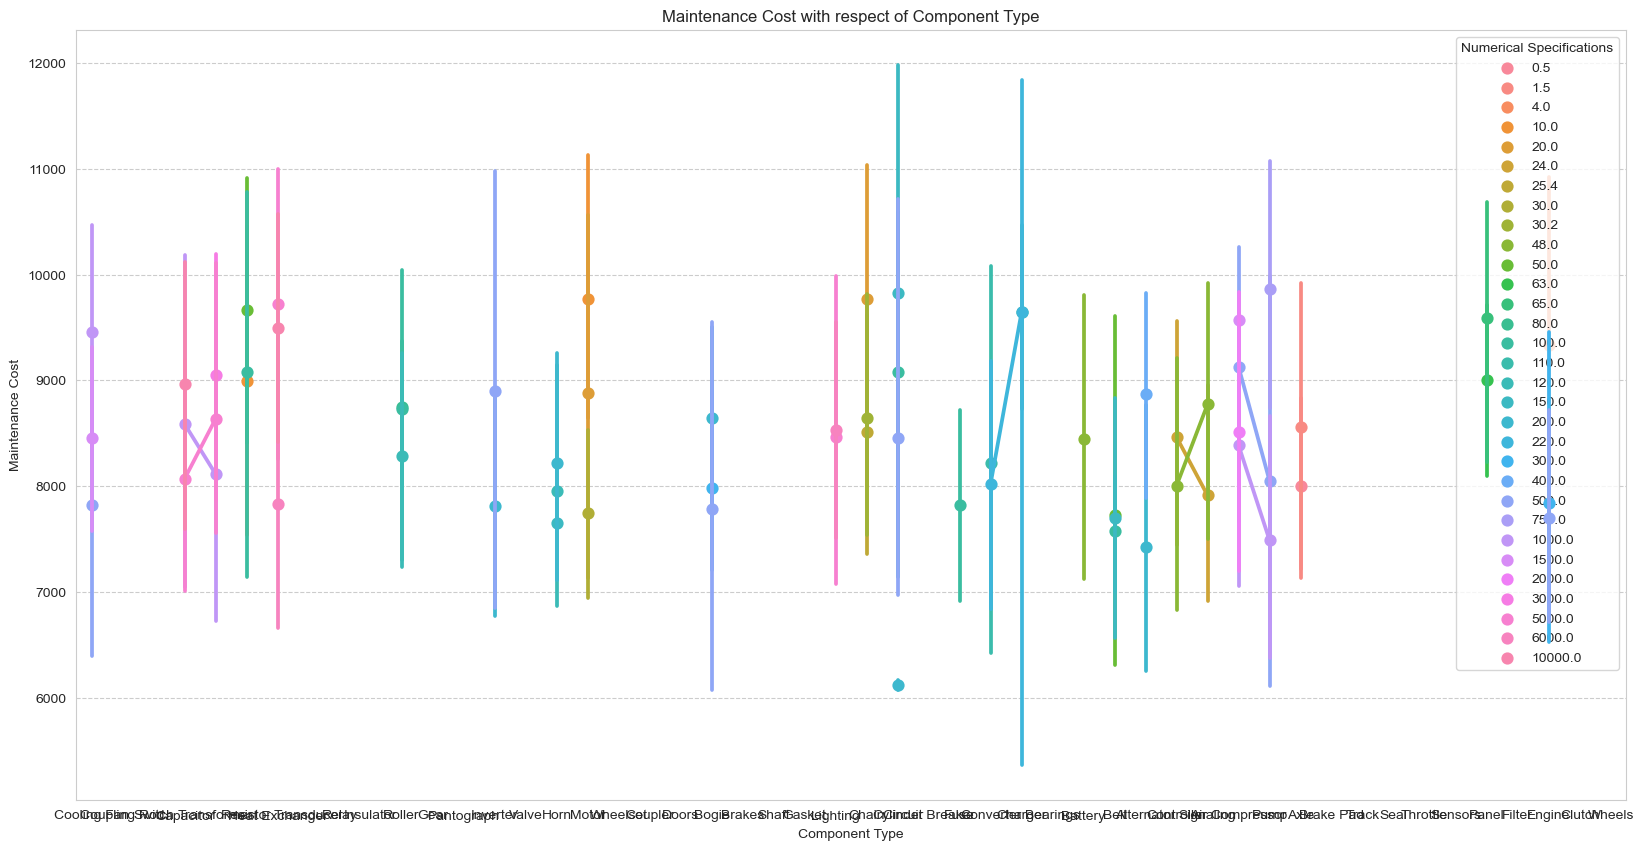

In [18]:
# we create point plots with Maintenance Cost  with respect of Component Type
plt.figure(figsize=(20,10))
sns.pointplot(x=df["Component Type"],y=df['Maintenance Cost'],hue=df[i])
plt.title(f"Maintenance Cost with respect of Component Type")
plt.show()

# Explore our numerical feature and Trying to take some important information from the Numeical feature

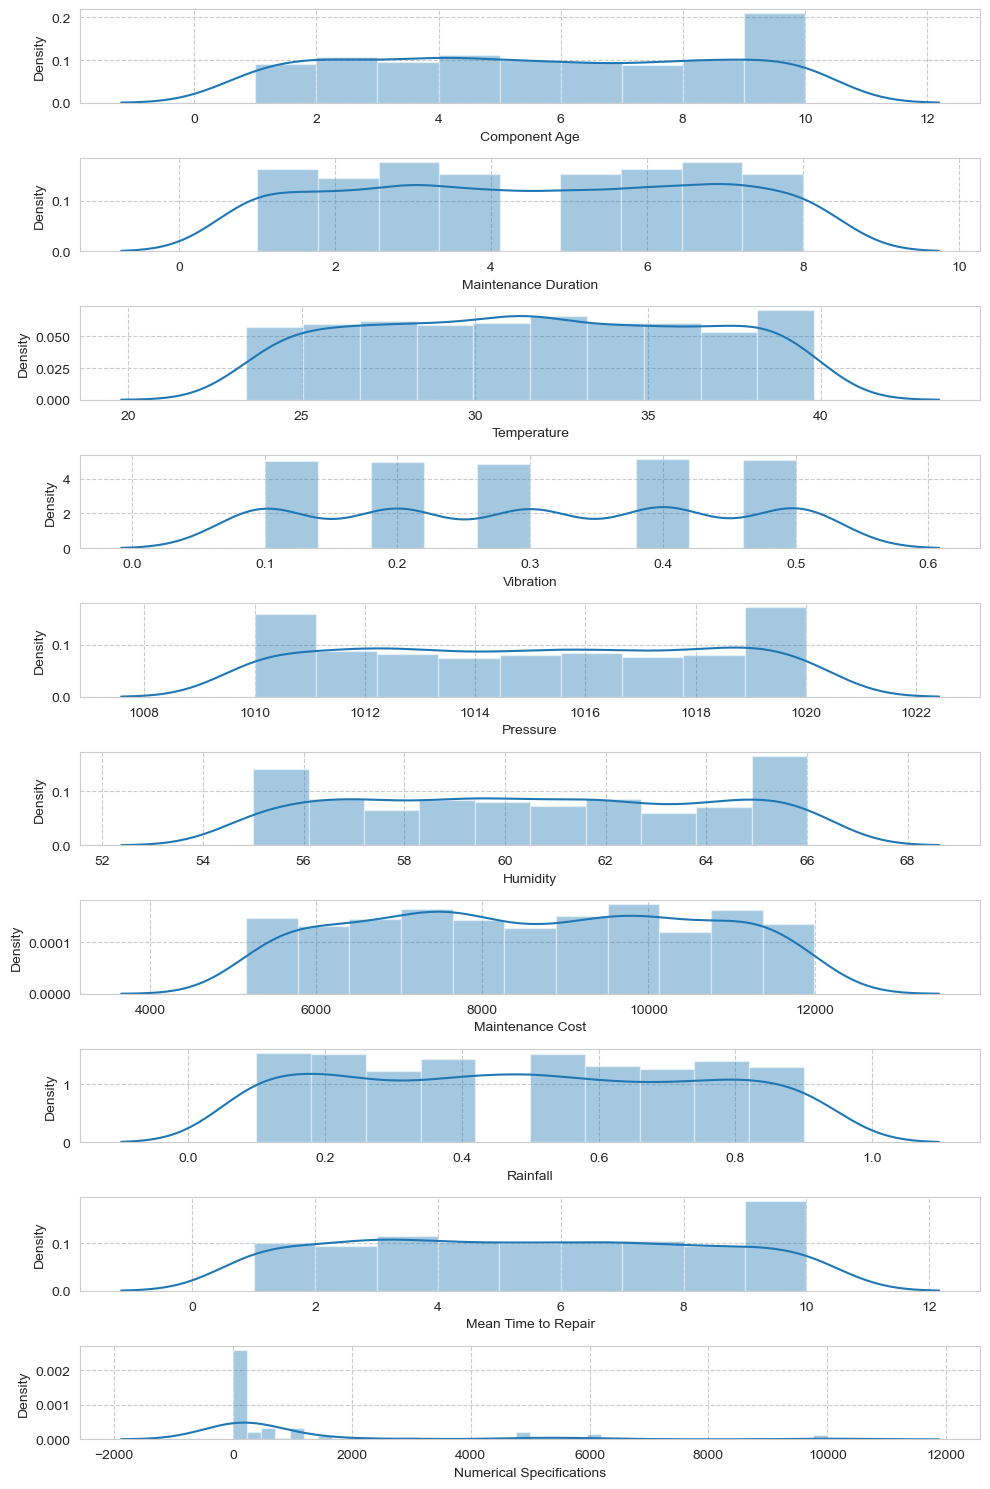

In [19]:
# Distrubution of Data
plt.figure(figsize=(10, 15))

n_rows = len(numeric_features.columns)
for n, col in enumerate(numeric_features.columns):
    plt.subplot(n_rows, 1, n+1)
    sns.distplot(df[col])
    plt.xlabel(col)

plt.tight_layout()
plt.show()


 In this plots we observe that some of our columns is right skewed and some are left skewed we have to remember this things when we apply algorithms

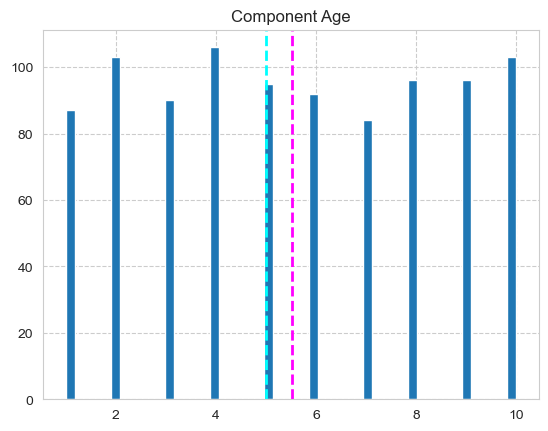

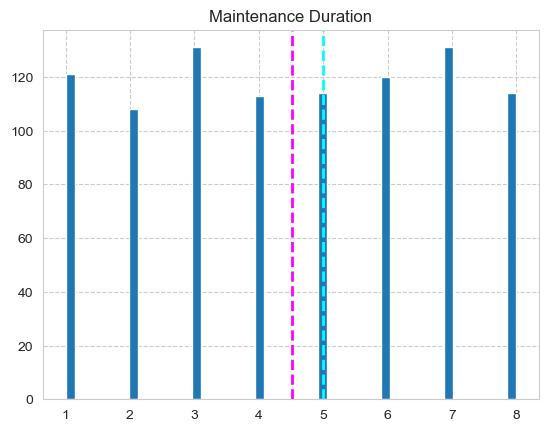

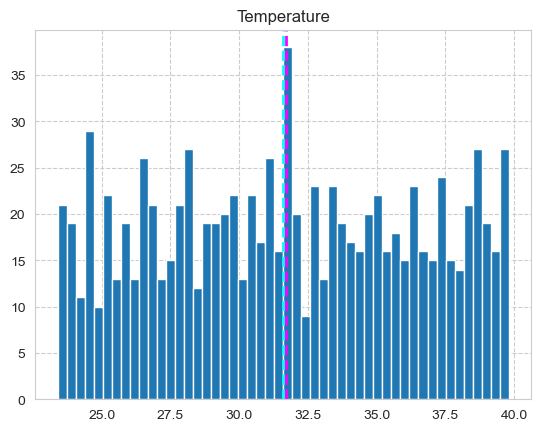

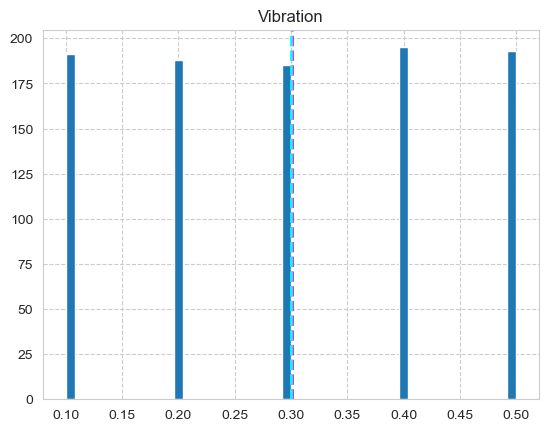

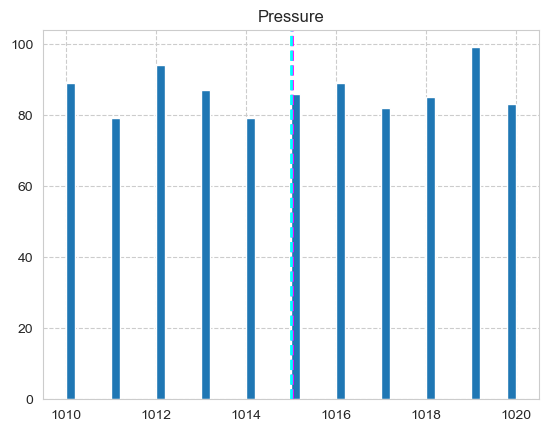

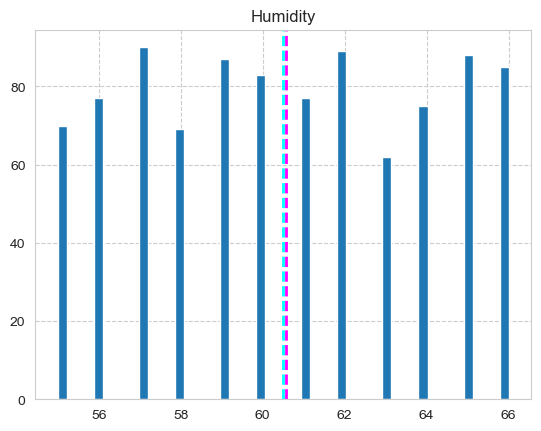

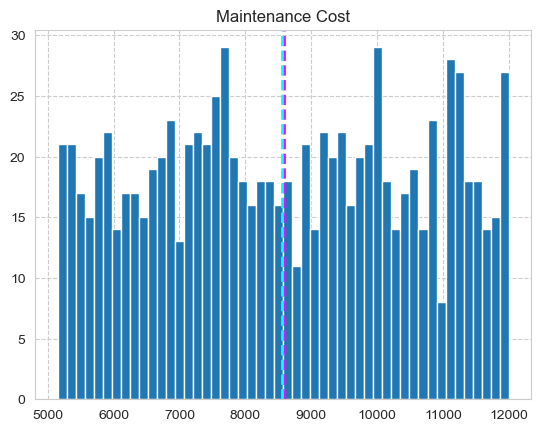

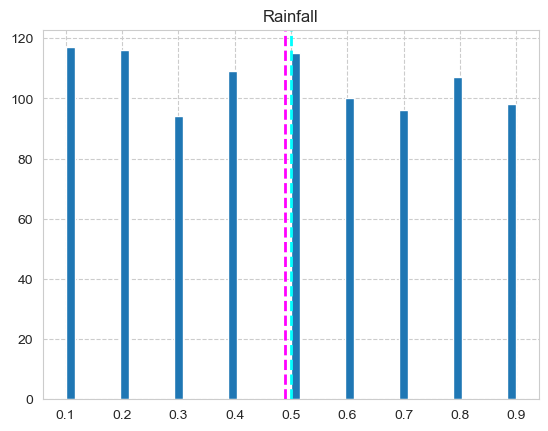

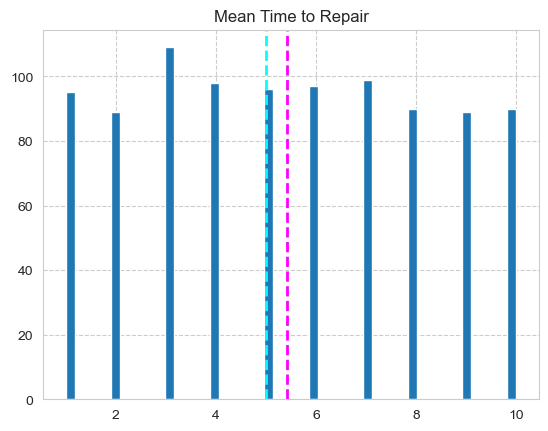

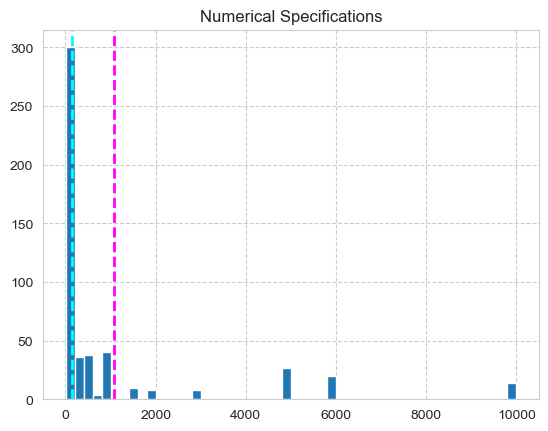

In [20]:
#plotting histogram of all the numeric features of the dataset
for col in numeric_features[:]:
    fig=plt.figure()
    ax=fig.gca()
    feature=df[col]
    feature.hist(bins=50,ax=ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    ax.set_title(col)

From this we are coming to know that the features which are skewed, their mean and the median are also skewed, which was understood by looking at the graph that this would happen.

# Lets try to find how is the relation of numerical features with our dependent variable

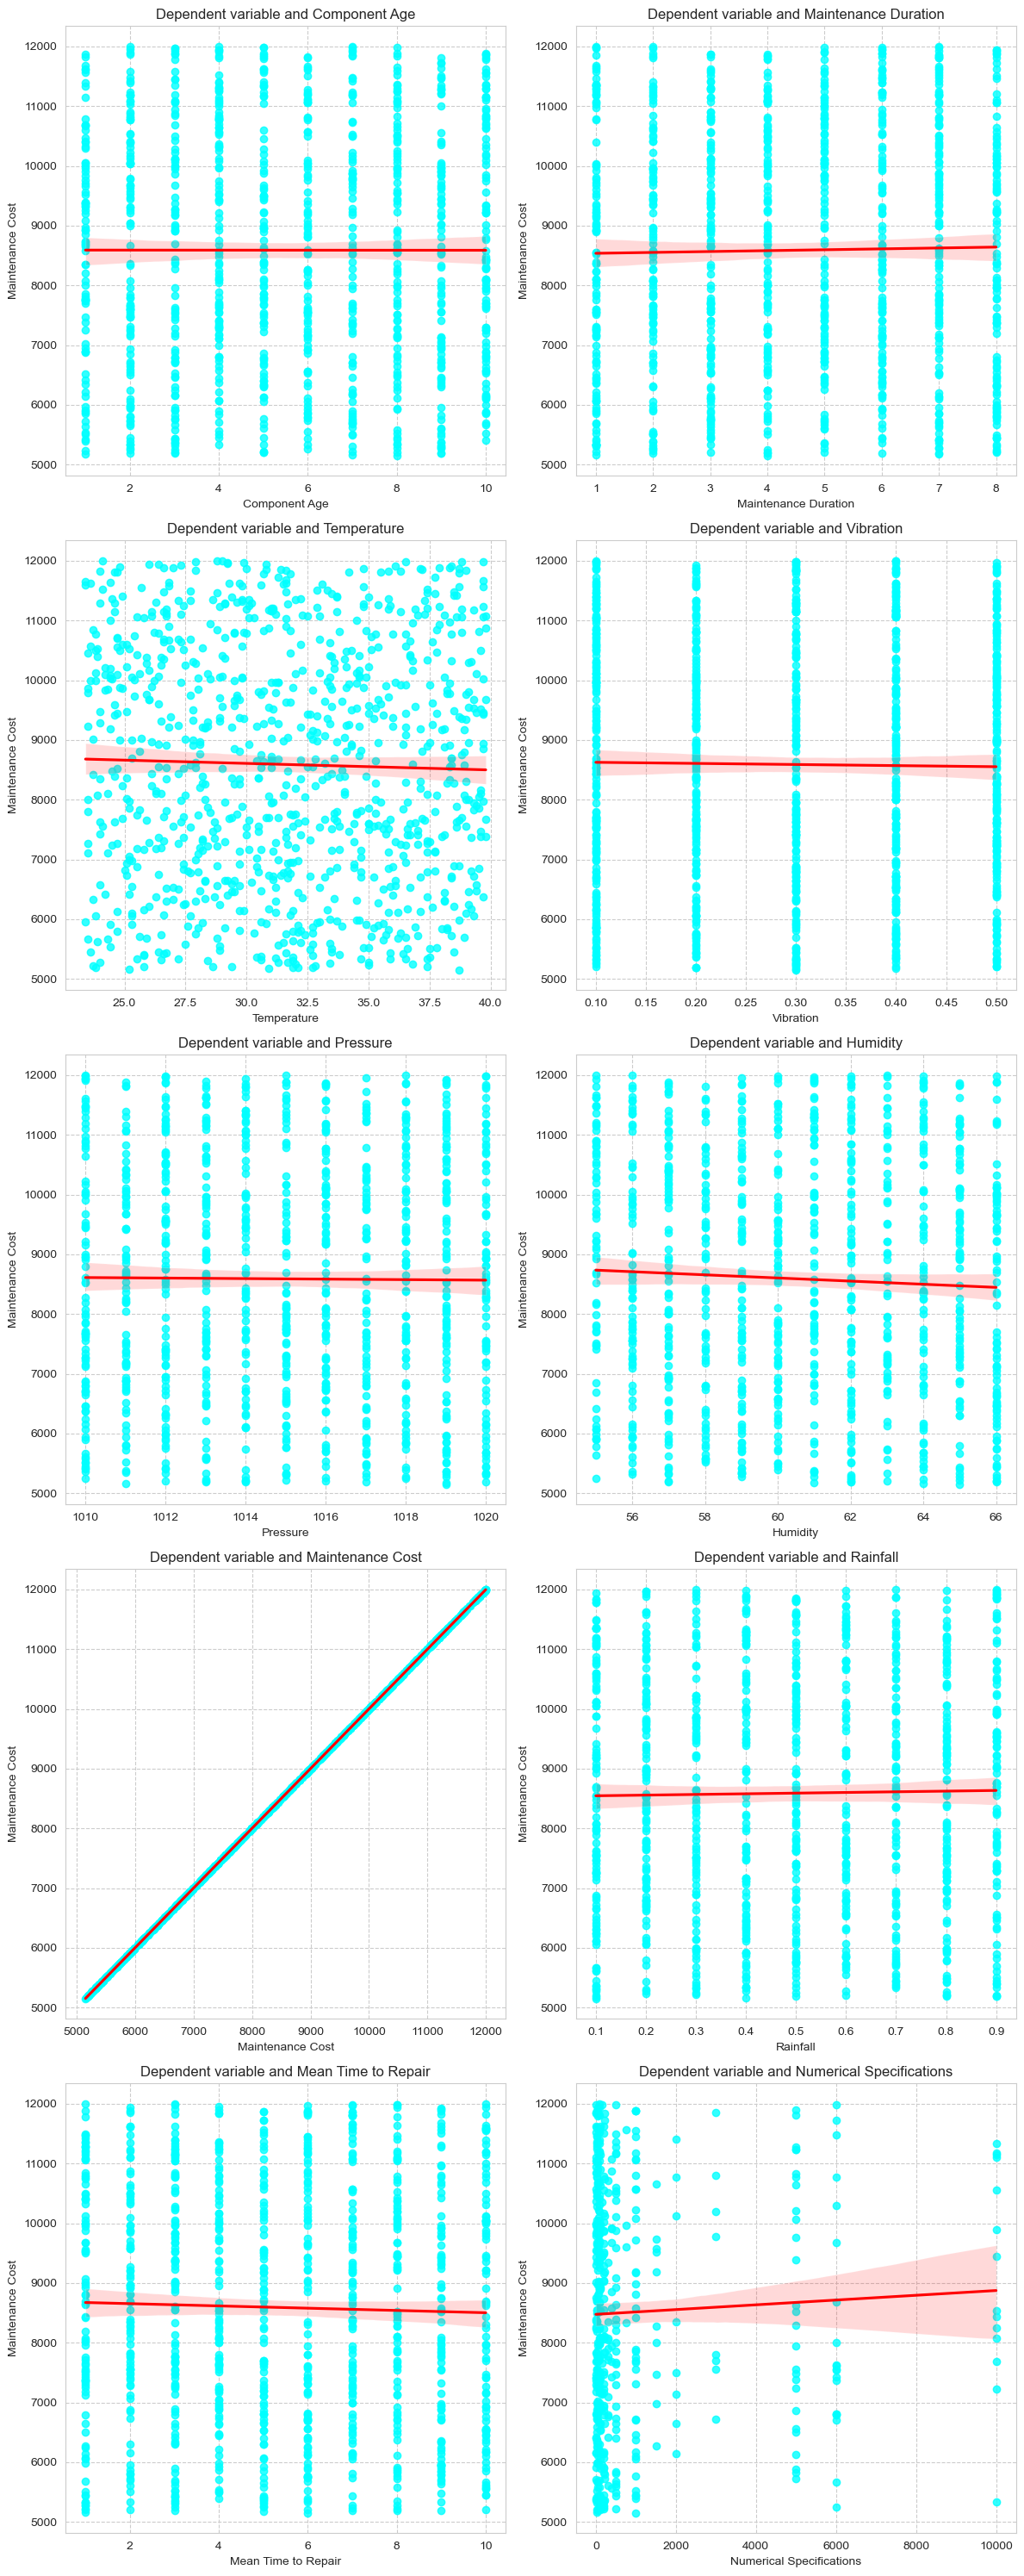

In [21]:
# Regression plot to know relation with our independent variable



# Calculate the number of rows and columns for subplot layout
n_rows = (len(numeric_features.columns) + 1) // 2
n_cols = min(len(numeric_features.columns), 2)

plt.figure(figsize=(12, n_rows * 6))

n = 1
for i in numeric_features.columns:
    plt.subplot(n_rows, n_cols, n)
    sns.regplot(x=i, y='Maintenance Cost', data=df, scatter_kws={"color": "cyan"}, line_kws={"color": "red"})
    plt.title(f'Dependent variable and {i}')
    n += 1

plt.tight_layout()
plt.show()


This regression plots shows that some of our features are positive linear and some are negative linear in relation to our target variable.

Now is the time to know what is the correlation of our dependent variable with the independent features

In [22]:
# Correlation with Rented Bike Count
df.corr()['Maintenance Cost']

Component Age              -0.000478
Maintenance Duration        0.017209
Temperature                -0.026297
Vibration                  -0.013244
Pressure                   -0.007053
Humidity                   -0.045809
Maintenance Cost            1.000000
Rainfall                    0.014602
Mean Time to Repair        -0.027292
Numerical Specifications    0.044017
Name: Maintenance Cost, dtype: float64

# We saw that our dependent variable is right skewed, it needs to be normalized.

Text(0.5, 1.0, 'Square root')

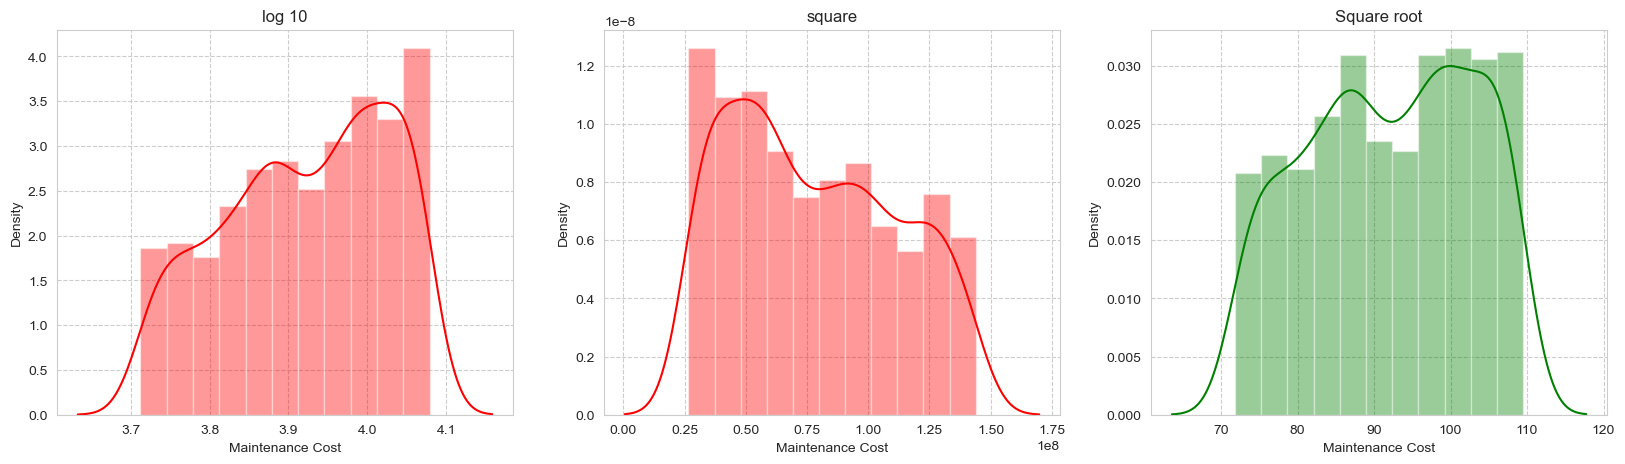

In [23]:
# trying normalise the data
fig,axes = plt.subplots(1,3,figsize=(20,5))
sns.distplot(np.log10(df['Maintenance Cost']+0.0000001),ax=axes[0],color='red').set_title("log 10")
sns.distplot((df['Maintenance Cost']**2),ax=axes[1],color='red').set_title("square")
sns.distplot(np.sqrt(df['Maintenance Cost']),ax=axes[2], color='green').set_title("Square root")

Our data in green plot is normalized to some extent: so we will go with square root on our dependent variable

# Splitting Dataset

In [24]:
#perform one-hot encoding on categorical columns
df = pd.get_dummies(df, columns=['Component Type', 'Maintenance Activity', 'Failure Causes', 'Failure History', 'Non-Numerical Specifications'])

# Splitting data into features (X) and target (y)
X = df.drop(columns=['Maintenance Cost'])
y = np.sqrt(df['Maintenance Cost'])

In [25]:
# Train test split our data
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25,random_state=42)

In [26]:
X_train.head()

,Component Age,Maintenance Duration,Temperature,Vibration,Pressure,Humidity,Rainfall,Mean Time to Repair,Numerical Specifications,Component Type_Air Compressor,...,Non-Numerical Specifications_Solenoid Valve,Non-Numerical Specifications_Stainless Steel,Non-Numerical Specifications_Standard Gauge,Non-Numerical Specifications_Steel,Non-Numerical Specifications_Sterlant,Non-Numerical Specifications_Temperature,Non-Numerical Specifications_Thermal,Non-Numerical Specifications_Toggle,Non-Numerical Specifications_Vibration,Non-Numerical Specifications_Wrought Iron
570,5,8,38.1,0.3,1012,62,0.9,7,48.0,0,...,0,0,0,0,0,0,0,0,0,0
382,6,4,26.7,0.4,1019,64,0.5,3,65.0,0,...,0,0,0,0,0,0,0,0,0,0
724,4,2,31.7,0.1,1013,59,0.1,8,NaN,0,...,0,0,0,0,0,0,0,0,0,0
327,9,6,37.4,0.1,1010,61,0.4,8,NaN,0,...,0,0,0,0,0,0,0,0,0,0
227,4,6,24.0,0.1,1020,57,0.2,2,NaN,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
y_train.head()

570     79.460682
382    105.422958
724     92.086915
327     84.386018
227     91.411159
Name: Maintenance Cost, dtype: float64

In [28]:
y_test.head()


230     98.270036
485    108.669223
800     73.389373
864     76.511437
581     94.572723
Name: Maintenance Cost, dtype: float64

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((714, 272), (238, 272), (714,), (238,))

# Creating a function for calculate score

In [30]:
def score_metrics(actual,predicted):
    mae = mean_absolute_error(actual**2,predicted**2)
    print('mean absolute error is  :',mae)
    mse = mean_squared_error(actual**2,predicted**2)
    print('mean squared error is  :',mse)
    print('Root mean squared error is  :',np.sqrt(mse))
    print("R2 score is  :", r2_score(actual**2, predicted**2))


In [31]:
# transforming X_train and X_test
yeo = PowerTransformer()
X_train = yeo.fit_transform(X_train)
X_test = yeo.transform(X_test)

# Model Training and Deployment

In [32]:
# Fitting the model

lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)




LGBMRegressor(random_state=42)

In [33]:
lgb_model.score(X_train,y_train)

0.8602436809626596

In [34]:
# predicting
y_pred = lgb_model.predict(X_test)

In [35]:
score_metrics(y_test,y_pred)

mean absolute error is  : 1788.2791704489682
mean squared error is  : 4560798.913972836
Root mean squared error is  : 2135.602705086514
R2 score is  : -0.15020505868551548
